**Data preparation**

1. Import all necessary libraries
2. Load datasets into Pandas DataFrame
3. Merge and clean up data, taking care of missing, duplicate, invalid values, and outliers
4. Feature engineer values for analysis

In [2]:
# Import all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt


In [3]:
# Load in datasets into Pandas DataFrame

complete = os.path.join(os.getcwd(), "covid_19_clean_complete.csv")
world = os.path.join(os.getcwd(), "worldometer_data.csv")
country_wise = os.path.join(os.getcwd(), "country_wise_latest.csv")

pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

complete = pd.read_csv(complete)
world = pd.read_csv(world)

In [4]:
complete.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.94,67.71,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15,20.17,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03,1.66,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.51,1.52,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20,17.87,2020-01-22,0,0,0,0,Africa


In [5]:
# Drop unnecessary columns
complete = complete.drop(columns=['Province/State', 'Lat', 'Long'], axis=1)

complete.head()

,Country/Region,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,Afghanistan,2020-01-22,0,0,0,0,Eastern Mediterranean
1,Albania,2020-01-22,0,0,0,0,Europe
2,Algeria,2020-01-22,0,0,0,0,Africa
3,Andorra,2020-01-22,0,0,0,0,Europe
4,Angola,2020-01-22,0,0,0,0,Africa


In [6]:
world.head()

,Country/Region,Continent,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,WHO Region
0,USA,North America,"331,198,130.00",5032179,NaN,"162,804.00",NaN,"2,576,668.00",NaN,"2,292,707.00","18,296.00","15,194.00",492.00,"63,139,605.00","190,640.00",Americas
1,Brazil,South America,"212,710,692.00",2917562,NaN,"98,644.00",NaN,"2,047,660.00",NaN,"771,258.00","8,318.00","13,716.00",464.00,"13,206,188.00","62,085.00",Americas
2,India,Asia,"1,381,344,997.00",2025409,NaN,"41,638.00",NaN,"1,377,384.00",NaN,"606,387.00","8,944.00","1,466.00",30.00,"22,149,351.00","16,035.00",South-EastAsia
3,Russia,Europe,"145,940,924.00",871894,NaN,"14,606.00",NaN,"676,357.00",NaN,"180,931.00","2,300.00","5,974.00",100.00,"29,716,907.00","203,623.00",Europe
4,South Africa,Africa,"59,381,566.00",538184,NaN,"9,604.00",NaN,"387,316.00",NaN,"141,264.00",539.00,"9,063.00",162.00,"3,149,807.00","53,044.00",Africa


In [7]:
# Drop unnecessary columns
world = world.drop(
    columns= [
        'TotalCases',
        'NewCases',
        'TotalDeaths',
        'NewDeaths',
        'TotalRecovered',
        'NewRecovered',
        'ActiveCases',
        'Serious,Critical',
        'Tot Cases/1M pop',
        'Deaths/1M pop',
        'TotalTests',
        'Tests/1M pop'
    ],
    axis=1
)

world.head()

,Country/Region,Continent,Population,WHO Region
0,USA,North America,"331,198,130.00",Americas
1,Brazil,South America,"212,710,692.00",Americas
2,India,Asia,"1,381,344,997.00",South-EastAsia
3,Russia,Europe,"145,940,924.00",Europe
4,South Africa,Africa,"59,381,566.00",Africa


In [8]:
# Checking for consistent country names
covid_countries = set(complete['Country/Region'].unique())
world_countries = set(world['Country/Region'].unique())

# Finding inconsistencies in country naming between datasets
country_name_differences = covid_countries.symmetric_difference(world_countries)

# Mapping inconsistencies to standardize country names
country_name_mapping = {
    'USA': 'United States',
    'US': 'United States',
    'UK': 'United Kingdom',
    'S. Korea': 'South Korea',
    'Burma': 'Myanmar',
    'Taiwan*': 'Taiwan',
    'Congo (Brazzaville)': 'Republic of Congo',
    'Congo (Kinshasa)': 'Democratic Republic of Congo',
    "Cote d'Ivoire": 'Ivory Coast',
    'CAR': 'Central African Republic',
    'UAE': 'United Arab Emirates',
    'Holy See': 'Vatican City',
    'West Bank and Gaza': 'Palestine',
    'Brunei ': 'Brunei',
    'Congo': 'Republic of Congo',
    'DRC': 'Democratic Republic of Congo',
    'China': 'Mainland China',
    'Diamond Princess': 'International Conveyance',
    'St. Vincent Grenadines': 'Saint Vincent and the Grenadines',
    'Sint Maarten': 'Saint Martin',
    'Curaçao': 'Curacao',
    'Faeroe Islands': 'Faroe Islands',
    'Réunion': 'Reunion',
    'Macao': 'Macau',
    'Turks and Caicos': 'Turks and Caicos Islands',
    'French Polynesia': 'French Polynesia',
    'French Guiana': 'French Guiana',
    'Channel Islands': 'Channel Islands',
    'Aruba': 'Aruba',
    'Bermuda': 'Bermuda',
    'Caribbean Netherlands': 'Caribbean Netherlands',
    'Cayman Islands': 'Cayman Islands',
    'Falkland Islands': 'Falkland Islands',
    'Hong Kong': 'Hong Kong SAR',
    'Isle of Man': 'Isle of Man',
    'Martinique': 'Martinique',
    'Mayotte': 'Mayotte',
    'Montserrat': 'Montserrat',
    'New Caledonia': 'New Caledonia',
    'Saint Martin': 'Saint Martin',
    'Kosovo': 'Kosovo'

}

# Applying the mapping to both datasets
complete['Country/Region'] = complete['Country/Region'].replace(country_name_mapping)
world['Country/Region'] = world['Country/Region'].replace(country_name_mapping)


In [ ]:
# Merge the 'complete' and 'worldometer' datasets to form a new dataset with desired features

covid_19_use = (complete
        .merge(world[['Country/Region', 'Population']],
        on='Country/Region',
        how='left'
    )
)

covid_19_use.head()

,Country/Region,Date,Confirmed,Deaths,Recovered,Active,WHO Region,Population
0,Afghanistan,2020-01-22,0,0,0,0,Eastern Mediterranean,"39,009,447.00"
1,Albania,2020-01-22,0,0,0,0,Europe,"2,877,470.00"
2,Algeria,2020-01-22,0,0,0,0,Africa,"43,926,079.00"
3,Andorra,2020-01-22,0,0,0,0,Europe,"77,278.00"
4,Angola,2020-01-22,0,0,0,0,Africa,"32,956,300.00"


In [10]:
# Arrange columns in desired sequence by reindexing
covid_19_use = covid_19_use.reindex(
    labels=['Date', 'Country/Region', 'WHO Region', 'Population', 'Confirmed', 'Deaths', 'Recovered', 'Active'], axis=1
)

# Date formatting
covid_19_use['Date'] = pd.to_datetime(covid_19_use['Date'], errors='coerce')

covid_19_use.head()

,Date,Country/Region,WHO Region,Population,Confirmed,Deaths,Recovered,Active
0,2020-01-22,Afghanistan,Eastern Mediterranean,"39,009,447.00",0,0,0,0
1,2020-01-22,Albania,Europe,"2,877,470.00",0,0,0,0
2,2020-01-22,Algeria,Africa,"43,926,079.00",0,0,0,0
3,2020-01-22,Andorra,Europe,"77,278.00",0,0,0,0
4,2020-01-22,Angola,Africa,"32,956,300.00",0,0,0,0


In [11]:
# Create additional features
covid_19_use = covid_19_use.assign(
    # Daily Growth Rate
    DailyGrowthRate = (covid_19_use.groupby('Country/Region')['Confirmed']
           .pct_change() * 100)
           .replace([np.inf, -np.inf], 0),

    # Case Fatality Rate
    CaseFatalityRate = (covid_19_use['Deaths'] / covid_19_use['Confirmed'] * 100)
           .replace([np.inf, -np.inf], 0),
       #     .fillna(0),

    # Case Recovery Rate
    CaseRecoveryRate = (covid_19_use['Recovered'] / covid_19_use['Confirmed'] *100)
           .replace([np.inf, -np.inf], 0),

    # Case Per Million
    CasePerMillion = (covid_19_use['Confirmed'] / (covid_19_use['Population'] / 1_000_000))
           .replace([np.inf, -np.inf], 0),

     # Death Per Million
     DeathPerMillion = (covid_19_use['Deaths'] / (covid_19_use['Population'] / 1_000_000))
           .replace([np.inf, -np.inf], 0),
)

# Sort DataFrame by 'Date' and 'Country/Region'
covid_19_use = covid_19_use.sort_values(['Date', 'Country/Region'])

# Drop duplicates
covid_19_use = covid_19_use.drop_duplicates(keep='first')

# Reindex the merged dataset to arrange columns in desired format
covid_19_use = covid_19_use.reindex(
    labels=[
        'Date',
        'Country/Region',
        'Population',
        'WHO Region',
        'Confirmed',
        'Deaths',
        'Recovered',
        'Active',
        'DailyGrowthRate',
        'CaseRecoveryRate',
        'CasePerMillion',
        'DeathPerMillion',
        'CaseFatalityRate'
    ],
    axis=1,

)

# Fill missing values
covid_19_use = covid_19_use.fillna(0)

covid_19_use.head(10)

,Date,Country/Region,Population,WHO Region,Confirmed,Deaths,Recovered,Active,DailyGrowthRate,CaseRecoveryRate,CasePerMillion,DeathPerMillion,CaseFatalityRate
0,2020-01-22,Afghanistan,"39,009,447.00",Eastern Mediterranean,0,0,0,0,0.00,0.00,0.00,0.00,0.00
1,2020-01-22,Albania,"2,877,470.00",Europe,0,0,0,0,0.00,0.00,0.00,0.00,0.00
2,2020-01-22,Algeria,"43,926,079.00",Africa,0,0,0,0,0.00,0.00,0.00,0.00,0.00
3,2020-01-22,Andorra,"77,278.00",Europe,0,0,0,0,0.00,0.00,0.00,0.00,0.00
4,2020-01-22,Angola,"32,956,300.00",Africa,0,0,0,0,0.00,0.00,0.00,0.00,0.00
5,2020-01-22,Antigua and Barbuda,"98,010.00",Americas,0,0,0,0,0.00,0.00,0.00,0.00,0.00
6,2020-01-22,Argentina,"45,236,884.00",Americas,0,0,0,0,0.00,0.00,0.00,0.00,0.00
7,2020-01-22,Armenia,"2,963,811.00",Europe,0,0,0,0,0.00,0.00,0.00,0.00,0.00
8,2020-01-22,Australia,"25,528,864.00",Western Pacific,0,0,0,0,0.00,0.00,0.00,0.00,0.00
16,2020-01-22,Austria,"9,011,577.00",Europe,0,0,0,0,0.00,0.00,0.00,0.00,0.00


In [12]:
covid_19_use.tail(10)

,Date,Country/Region,Population,WHO Region,Confirmed,Deaths,Recovered,Active,DailyGrowthRate,CaseRecoveryRate,CasePerMillion,DeathPerMillion,CaseFatalityRate
49030,2020-07-27,United States,"331,198,130.00",Americas,4290259,148011,1325804,2816444,1.33,30.90,"12,953.75",446.90,3.45
49029,2020-07-27,Uruguay,"3,474,956.00",Americas,1202,35,951,216,0.84,79.12,345.90,10.07,2.91
49031,2020-07-27,Uzbekistan,"33,516,027.00",Europe,21209,121,11674,9414,3.30,55.04,632.80,3.61,0.57
48932,2020-07-27,Vatican City,801.00,Europe,12,0,12,0,0.00,100.00,"14,981.27",0.00,0.00
49032,2020-07-27,Venezuela,"28,427,499.00",Americas,15988,146,9959,5883,3.40,62.29,562.41,5.14,0.91
49033,2020-07-27,Vietnam,"97,425,470.00",Western Pacific,431,0,365,66,2.62,84.69,4.42,0.00,0.00
49062,2020-07-27,Western Sahara,"598,682.00",Africa,10,1,8,1,0.00,80.00,16.70,1.67,10.00
49064,2020-07-27,Yemen,"29,886,897.00",Eastern Mediterranean,1691,483,833,375,0.59,49.26,56.58,16.16,28.56
49034,2020-07-27,Zambia,"18,430,129.00",Africa,4552,140,2815,1597,1.58,61.84,246.99,7.60,3.08
49035,2020-07-27,Zimbabwe,"14,883,803.00",Africa,2704,36,542,2126,7.64,20.04,181.67,2.42,1.33


In [13]:
covid_19_use.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 47489 entries, 0 to 49035
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              47489 non-null  datetime64[ns]
 1   Country/Region    47489 non-null  object        
 2   Population        47489 non-null  float64       
 3   WHO Region        47489 non-null  object        
 4   Confirmed         47489 non-null  int64         
 5   Deaths            47489 non-null  int64         
 6   Recovered         47489 non-null  int64         
 7   Active            47489 non-null  int64         
 8   DailyGrowthRate   47489 non-null  float64       
 9   CaseRecoveryRate  47489 non-null  float64       
 10  CasePerMillion    47489 non-null  float64       
 11  DeathPerMillion   47489 non-null  float64       
 12  CaseFatalityRate  47489 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(4), object(2)
memory usage: 9.7 MB


In [14]:
covid_19_use.describe()

,Date,Population,Confirmed,Deaths,Recovered,Active,DailyGrowthRate,CaseRecoveryRate,CasePerMillion,DeathPerMillion,CaseFatalityRate
count,47489,"47,489.00","47,489.00","47,489.00","47,489.00","47,489.00","47,489.00","47,489.00","47,489.00","47,489.00","47,489.00"
mean,2020-04-26 19:52:21.215860480,"31,199,477.20","17,446.32",913.58,"8,178.91","8,353.84","6,777.68",39.01,656.80,24.11,2.30
min,2020-01-22 00:00:00,0.00,0.00,0.00,0.00,-14.00,-100.00,0.00,0.00,0.00,0.00
25%,2020-03-13 00:00:00,"897,095.00",7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2020-04-28 00:00:00,"9,449,001.00",188.00,2.00,41.00,33.00,0.19,27.63,6.66,0.01,0.82
75%,2020-06-12 00:00:00,"36,953,359.00","1,634.00",34.00,742.00,673.00,6.11,79.57,231.71,4.40,3.00
max,2020-07-27 00:00:00,"1,381,344,997.00","4,290,259.00","148,011.00","1,846,641.00","2,816,444.00","2,619,290.91",100.19,"39,032.98","1,237.55",100.00
std,NaN,"95,512,948.02","129,361.44","6,415.60","55,685.22","77,501.87","107,178.15",38.55,"2,243.34",100.52,4.12


In [15]:
# The 'Active' columns has some negative values, which is not right as active cases cannot be negative.
# Handle negative values in the active cases

covid_19_use['Active'] = covid_19_use['Active'].clip(lower=0)

covid_19_use.describe()

,Date,Population,Confirmed,Deaths,Recovered,Active,DailyGrowthRate,CaseRecoveryRate,CasePerMillion,DeathPerMillion,CaseFatalityRate
count,47489,"47,489.00","47,489.00","47,489.00","47,489.00","47,489.00","47,489.00","47,489.00","47,489.00","47,489.00","47,489.00"
mean,2020-04-26 19:52:21.215860480,"31,199,477.20","17,446.32",913.58,"8,178.91","8,353.84","6,777.68",39.01,656.80,24.11,2.30
min,2020-01-22 00:00:00,0.00,0.00,0.00,0.00,0.00,-100.00,0.00,0.00,0.00,0.00
25%,2020-03-13 00:00:00,"897,095.00",7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2020-04-28 00:00:00,"9,449,001.00",188.00,2.00,41.00,33.00,0.19,27.63,6.66,0.01,0.82
75%,2020-06-12 00:00:00,"36,953,359.00","1,634.00",34.00,742.00,673.00,6.11,79.57,231.71,4.40,3.00
max,2020-07-27 00:00:00,"1,381,344,997.00","4,290,259.00","148,011.00","1,846,641.00","2,816,444.00","2,619,290.91",100.19,"39,032.98","1,237.55",100.00
std,NaN,"95,512,948.02","129,361.44","6,415.60","55,685.22","77,501.87","107,178.15",38.55,"2,243.34",100.52,4.12


In [16]:
covid_19_use.isna().sum().sum()

0

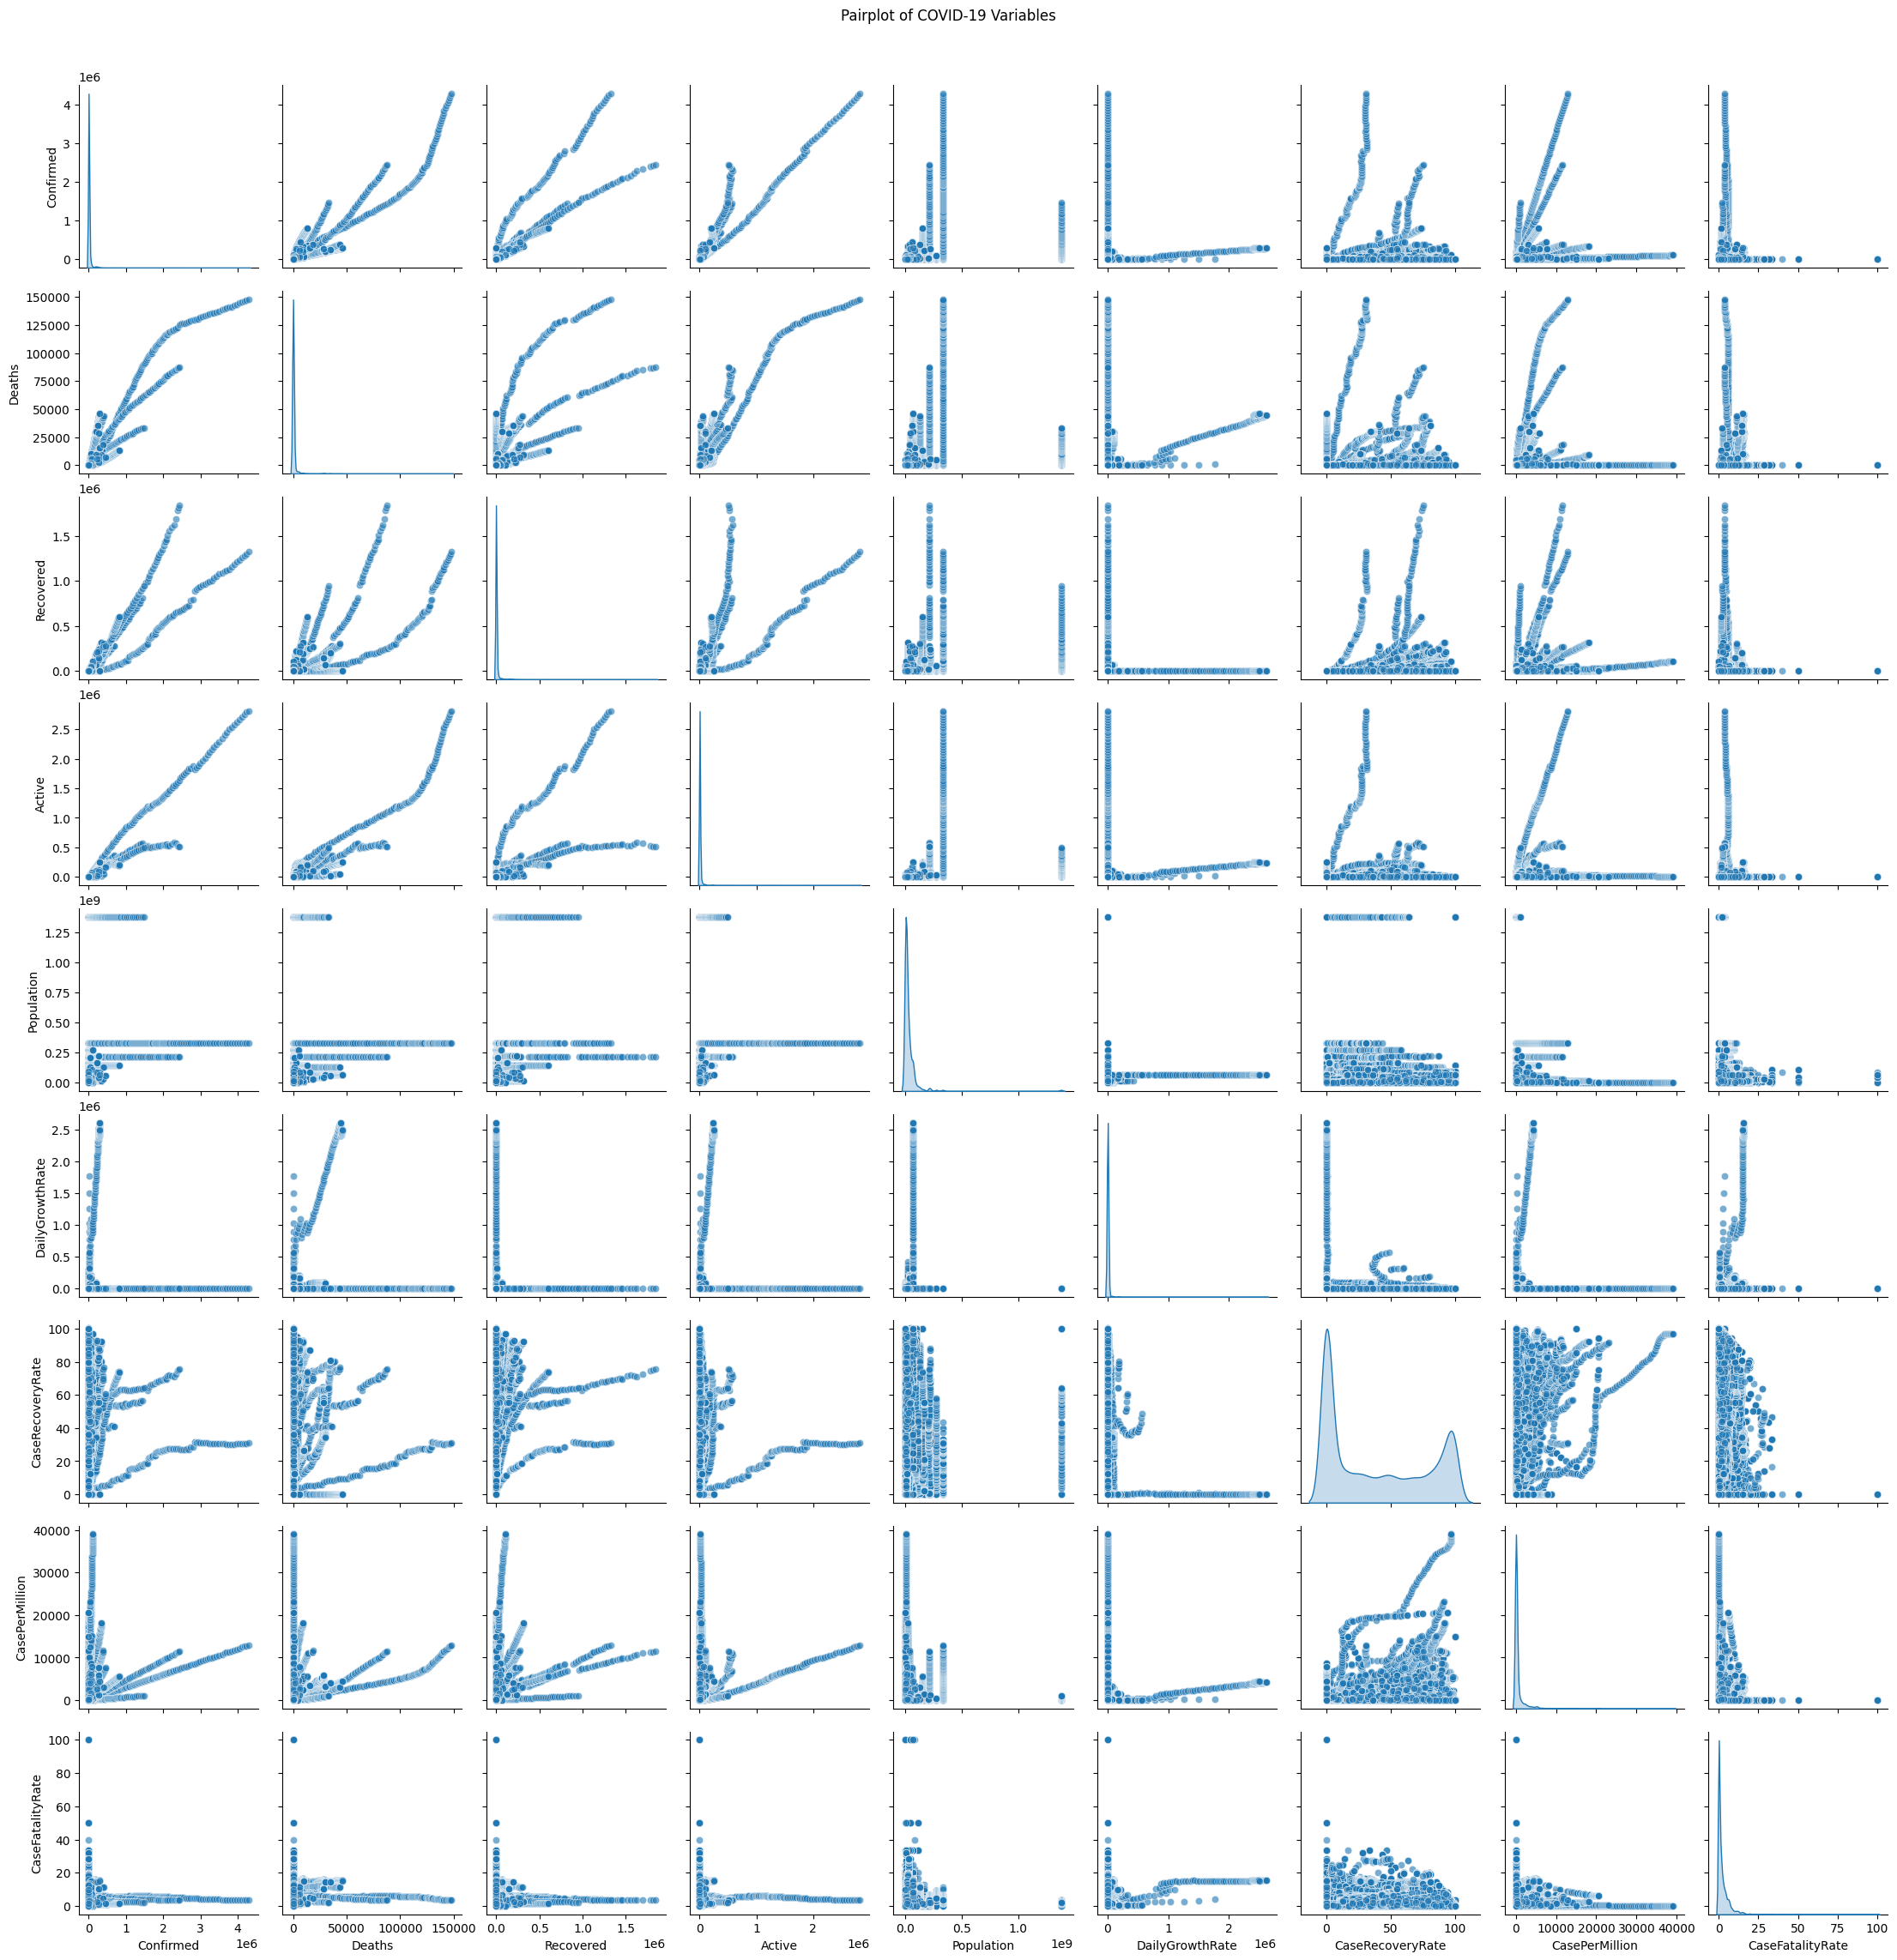

Top 10 strongest correlations:
Active - Confirmed: 0.95
Deaths - Confirmed: 0.91
Recovered - Confirmed: 0.90
Active - Deaths: 0.89
Recovered - Deaths: 0.76
Active - Recovered: 0.71
CasePerMillion - Recovered: 0.30
DailyGrowthRate - Deaths: 0.28
Population - Recovered: 0.27
Population - Confirmed: 0.26


In [18]:
# Select relevant numerical columns for correlation analysis
columns_for_correlation = [
    'Confirmed', 
    'Deaths', 
    'Recovered', 
    'Active', 
    'Population', 
    'DailyGrowthRate', 
    'CaseRecoveryRate', 
    'CasePerMillion', 
    'CaseFatalityRate'
]

# Pairplot for a more detailed view
sns.pairplot(covid_19_use[columns_for_correlation], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of COVID-19 Variables', y=1.02)
plt.show()

# Calculate the correlation matrix
correlation_matrix = covid_19_use[columns_for_correlation].corr()

# Calculate and print the strongest correlations
def get_top_correlations(corr_matrix, n=10):
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            corr_pairs.append((corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    return sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:n]

top_correlations = get_top_correlations(correlation_matrix)
print("Top 10 strongest correlations:")
for var1, var2, corr in top_correlations:
    print(f"{var1} - {var2}: {corr:.2f}")

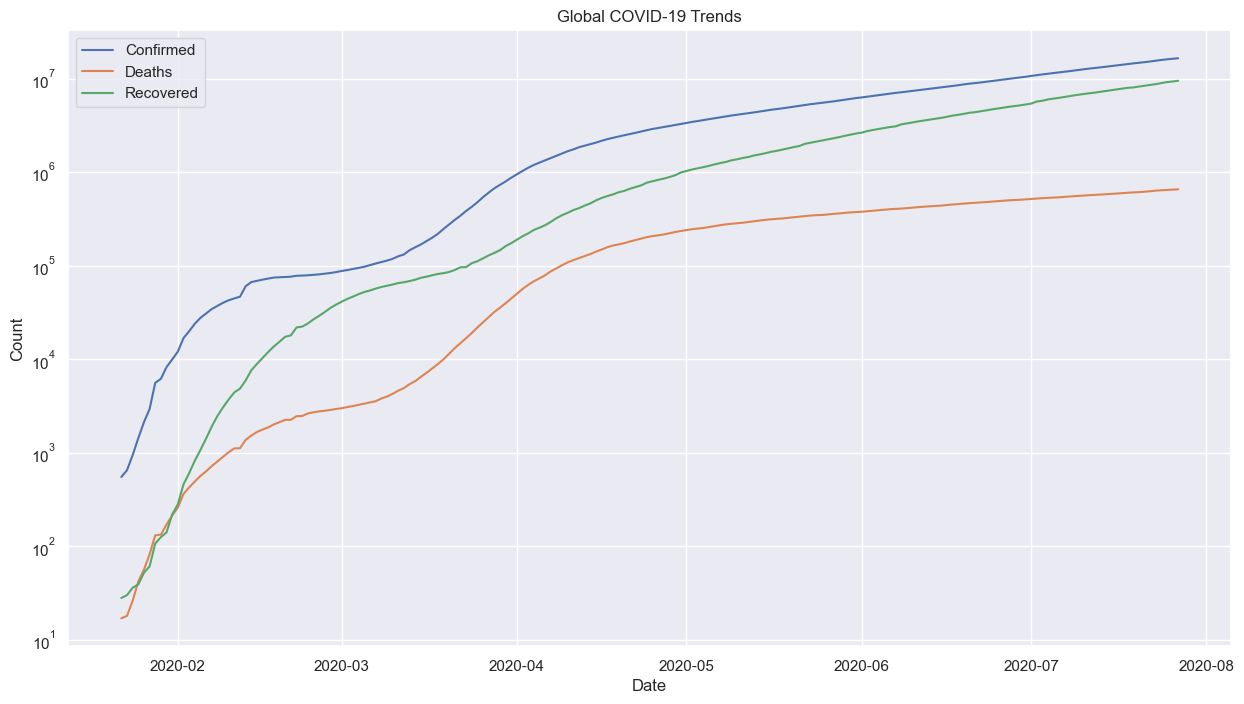

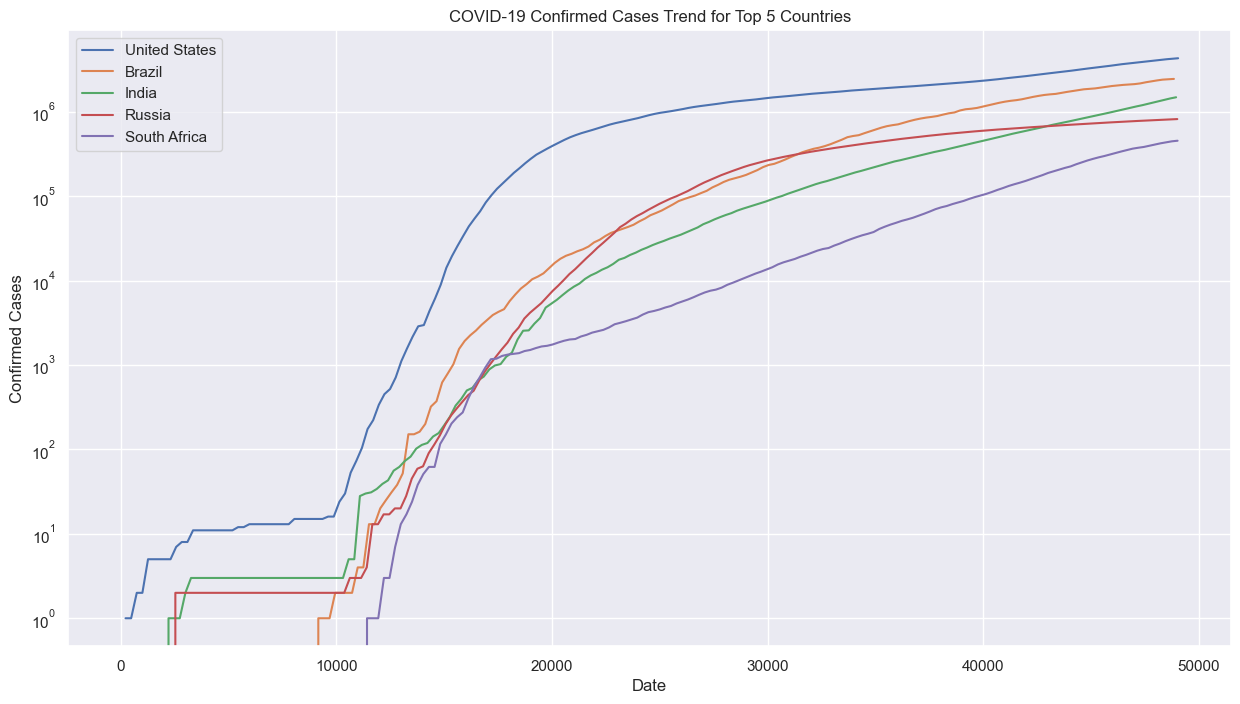

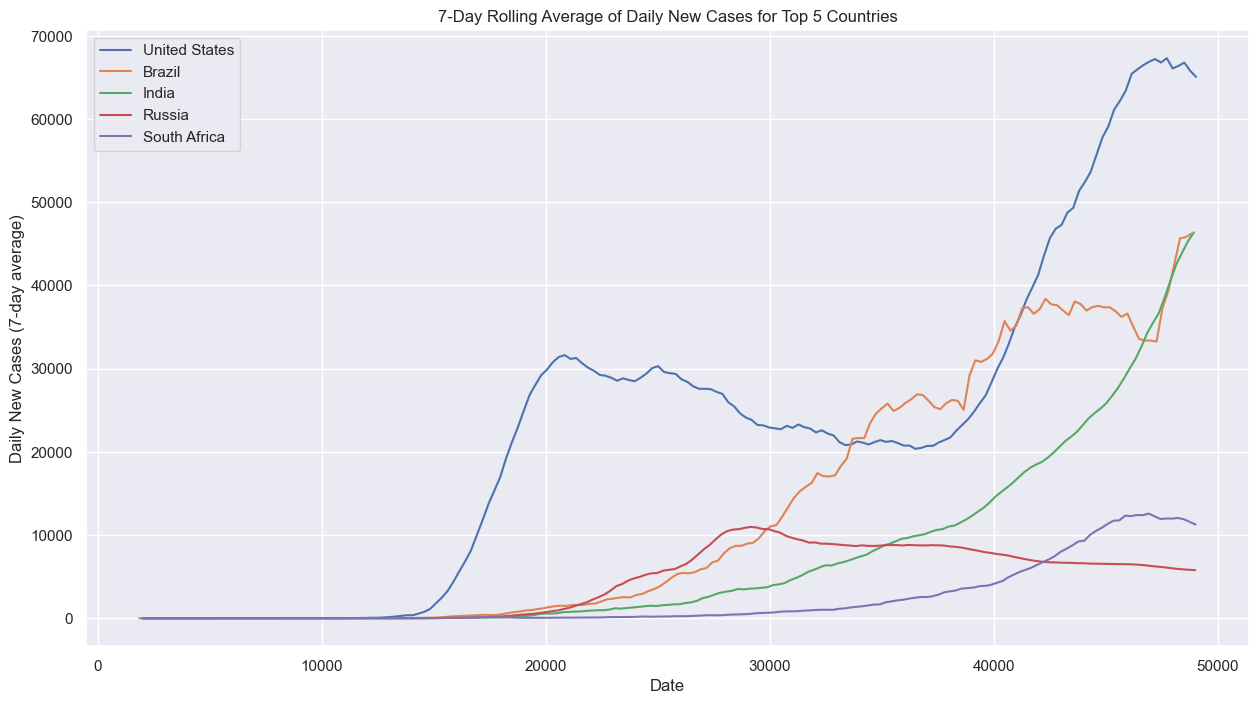

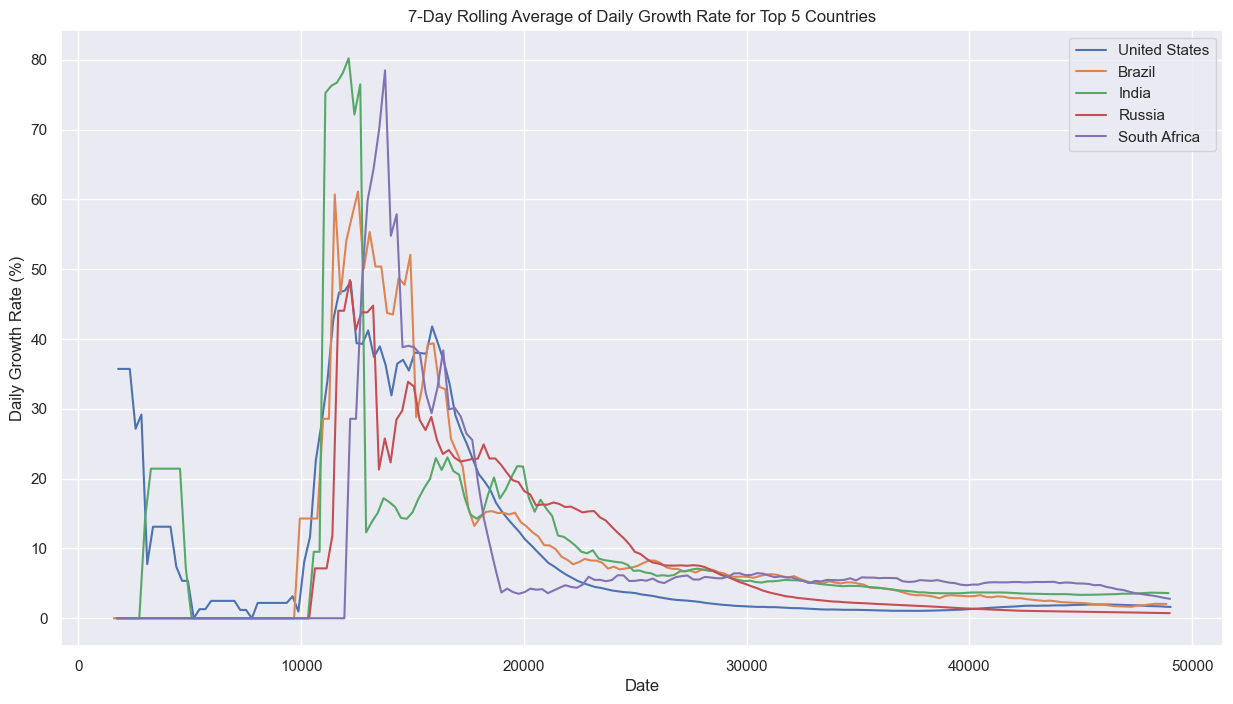

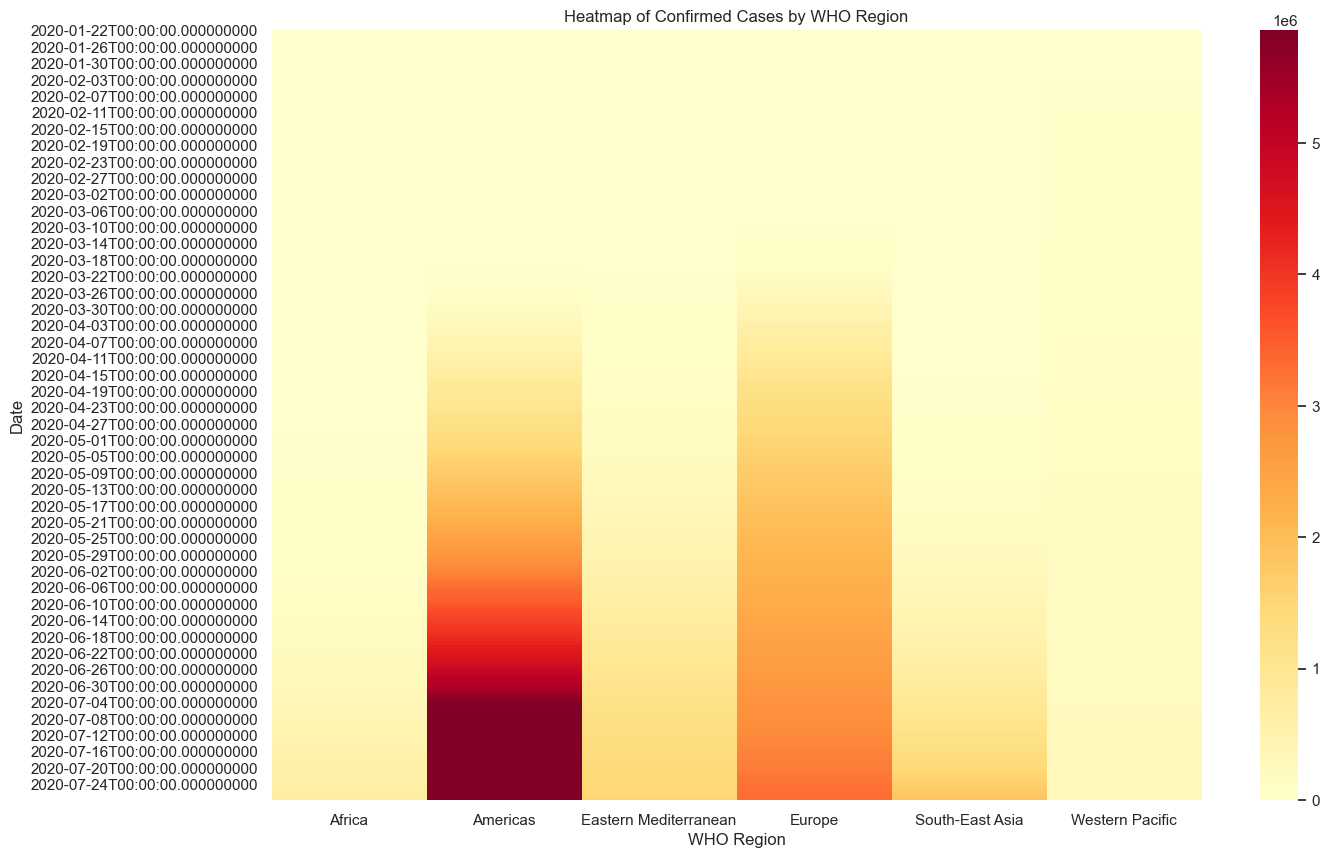

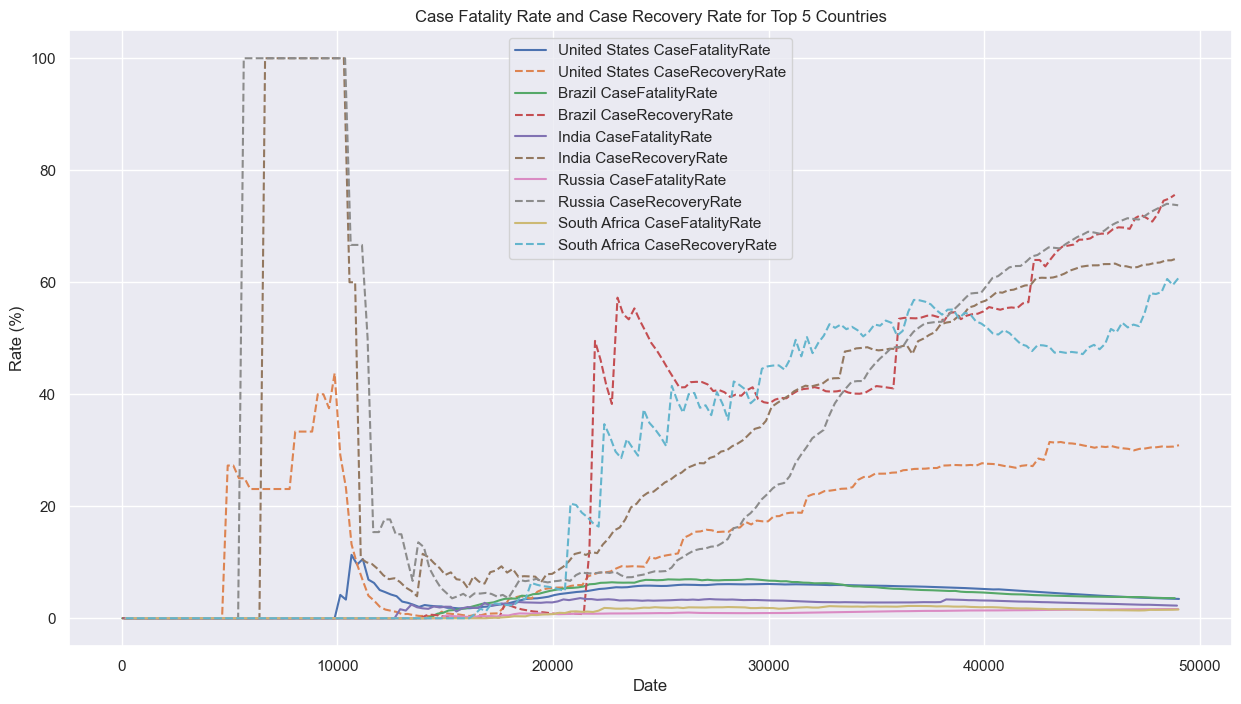

In [19]:
# Set the style for better-looking plots
sns.set_theme()

# 1. Global trends of confirmed cases, deaths, and recoveries
plt.figure(figsize=(15, 8))
global_data = covid_19_use.groupby('Date').sum()
plt.plot(global_data.index, global_data['Confirmed'], label='Confirmed')
plt.plot(global_data.index, global_data['Deaths'], label='Deaths')
plt.plot(global_data.index, global_data['Recovered'], label='Recovered')
plt.title('Global COVID-19 Trends')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

# 2. Top 5 countries by confirmed cases
top_5_countries = covid_19_use.groupby('Country/Region')['Confirmed'].max().nlargest(5).index

plt.figure(figsize=(15, 8))
for country in top_5_countries:
    country_data = covid_19_use[covid_19_use['Country/Region'] == country]
    plt.plot(country_data.index, country_data['Confirmed'], label=country)

plt.title('COVID-19 Confirmed Cases Trend for Top 5 Countries')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

# 3. Daily new cases for top 5 countries
plt.figure(figsize=(15, 8))
for country in top_5_countries:
    country_data = covid_19_use[covid_19_use['Country/Region'] == country]
    daily_new = country_data['Confirmed'].diff().rolling(window=7).mean()
    plt.plot(country_data.index, daily_new, label=country)

plt.title('7-Day Rolling Average of Daily New Cases for Top 5 Countries')
plt.xlabel('Date')
plt.ylabel('Daily New Cases (7-day average)')
plt.legend()
plt.grid(True)
plt.show()

# 4. Daily Growth Rate for top 5 countries
plt.figure(figsize=(15, 8))
for country in top_5_countries:
    country_data = covid_19_use[covid_19_use['Country/Region'] == country]
    plt.plot(country_data.index, country_data['DailyGrowthRate'].rolling(window=7).mean(), label=country)

plt.title('7-Day Rolling Average of Daily Growth Rate for Top 5 Countries')
plt.xlabel('Date')
plt.ylabel('Daily Growth Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

# 5. Heatmap of confirmed cases by WHO Region
region_data = covid_19_use.groupby(['Date', 'WHO Region'])['Confirmed'].sum().unstack()
plt.figure(figsize=(15, 10))
sns.heatmap(region_data, cmap='YlOrRd', robust=True)
plt.title('Heatmap of Confirmed Cases by WHO Region')
plt.ylabel('Date')
plt.show()

# 6. Comparison of CaseFatalityRate and CaseRecoveryRate for top 5 countries
plt.figure(figsize=(15, 8))
for country in top_5_countries:
    country_data = covid_19_use[covid_19_use['Country/Region'] == country]
    plt.plot(country_data.index, country_data['CaseFatalityRate'], label=f'{country} CaseFatalityRate')
    plt.plot(country_data.index, country_data['CaseRecoveryRate'], label=f'{country} CaseRecoveryRate', linestyle='--')

plt.title('Case Fatality Rate and Case Recovery Rate for Top 5 Countries')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

*Insights from plots of Global COVID-19 trends*


1. Between February and August, 2020, all confirmed cases, deaths, and recovered cases follow an upward exponential trajectory, indicating an expontential growth, typical of most pathogens.
2. The 5 most affected countries are U.S.A, Brazil, India, Russia, and South Africa
3. The Americas and Europe are the 2 most affected WHO regions, possibly because:
    a. Population Density: Highly populated and dense areas, such as regions in the Americas and Europe, are more prone to faster virus transmission due to close contact between individuals
    b.Travel Patterns: The Americas and Europe are hubs for international travel, facilitating the rapid spread of the virus during the early phases of the pandemic.

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3103.881, Time=0.52 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3104.348, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3103.243, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3104.882, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=3104.930, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=3102.358, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=3101.680, Time=0.12 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=3106.761, Time=0.13 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=3104.762, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=3099.443, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=3100.192, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=3098.220, Time=0.13 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=3100.455, Time=0.05 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : 

c:\Users\Hello World!\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hello World!\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hello World!\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


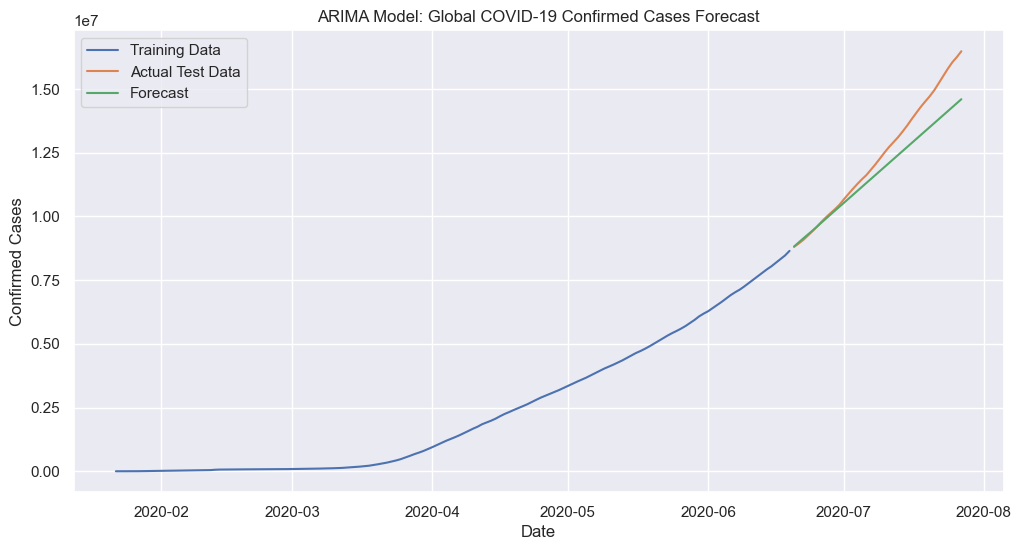

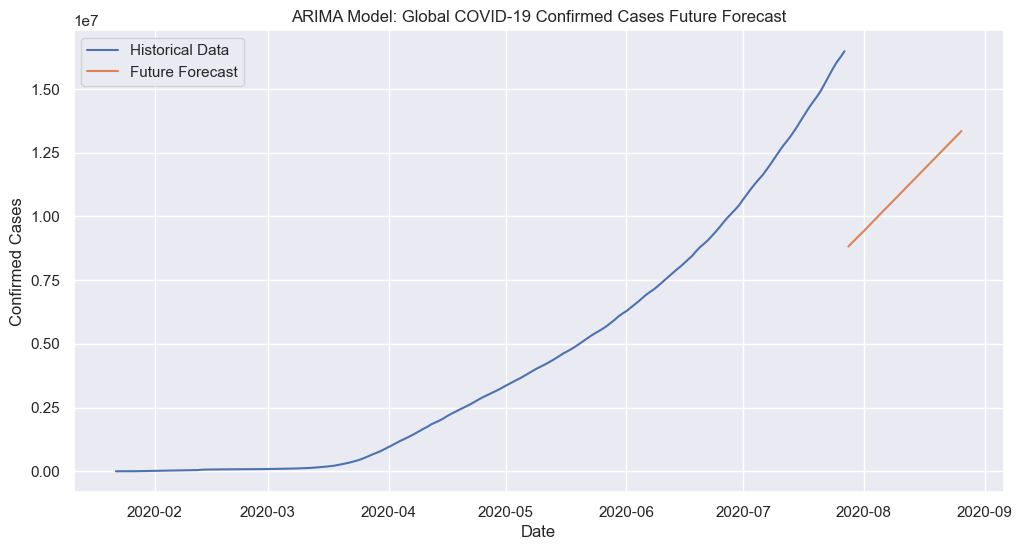


Forecasted values for the next 30 days:
2020-07-28: 8817903
2020-07-29: 8974105
2020-07-30: 9129958
2020-07-31: 9281240
2020-08-01: 9430430
2020-08-02: 9587250
2020-08-03: 9746781
2020-08-04: 9905172
2020-08-05: 10063230
2020-08-06: 10219646
2020-08-07: 10374425
2020-08-08: 10529821
2020-08-09: 10686153
2020-08-10: 10842887
2020-08-11: 10999930
2020-08-12: 11156808
2020-08-13: 11313191
2020-08-14: 11469377
2020-08-15: 11625611
2020-08-16: 11781955
2020-08-17: 11938459
2020-08-18: 12095042
2020-08-19: 12251572
2020-08-20: 12408025
2020-08-21: 12564432
2020-08-22: 12720826
2020-08-23: 12877246
2020-08-24: 13033704
2020-08-25: 13190176
2020-08-26: 13346643


In [20]:
# Prepare the data for ARIMA modeling
global_cases = covid_19_use.groupby('Date')['Confirmed'].sum().reset_index()
global_cases.set_index('Date', inplace=True)

# Split the data into training and testing sets
train_size = int(len(global_cases) * 0.8)
train, test = global_cases[:train_size], global_cases[train_size:]

# Use auto_arima to find the best ARIMA parameters
model_autoARIMA = auto_arima(train, start_p=0, start_q=0, test='adf', max_p=5, max_q=5, 
                             m=1, d=None, seasonal=False, start_P=0, D=0, trace=True, 
                             error_action='ignore', suppress_warnings=True, stepwise=True)

# Fit the ARIMA model
model = ARIMA(train, order=model_autoARIMA.order)
results = model.fit()

# Make predictions
forecast = results.forecast(steps=len(test))

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast, label='Forecast')
plt.title('ARIMA Model: Global COVID-19 Confirmed Cases Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

# Forecast future cases
future_forecast = results.forecast(steps=30)  # Forecast for the next 30 days

# Plot the future forecast
plt.figure(figsize=(12, 6))
plt.plot(global_cases.index, global_cases, label='Historical Data')
plt.plot(pd.date_range(start=global_cases.index[-1] + pd.Timedelta(days=1), periods=30), future_forecast, label='Future Forecast')
plt.title('ARIMA Model: Global COVID-19 Confirmed Cases Future Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

# Print the forecasted values
print("\nForecasted values for the next 30 days:")
for date, value in zip(pd.date_range(start=global_cases.index[-1] + pd.Timedelta(days=1), periods=30), future_forecast):
    print(f"{date.date()}: {value:.0f}")

*Key insights from Global COVID-19 ARIMA plot*:

1. The historical data shows a steady increase in the global COVID-19 confirmed cases over the time period displayed.

2. The ARIMA model's forecast predicts a continued, accelerating growth in the number of global COVID-19 confirmed cases in the future.

3. The forecast line suggests that the number of confirmed cases will continue to rise sharply, indicating an expectation of the pandemic situation         worsening in the coming months.

4. The forecast extends out to 2020-09, implying that the ARIMA model is predicting the pandemic to persist and the number of confirmed cases to keep growing through at least the end of September 2020.



Random Forest - RMSE: 1.7569, R2 Score: 0.6736
Gradient Boosting - RMSE: 1.1500, R2 Score: 0.8601


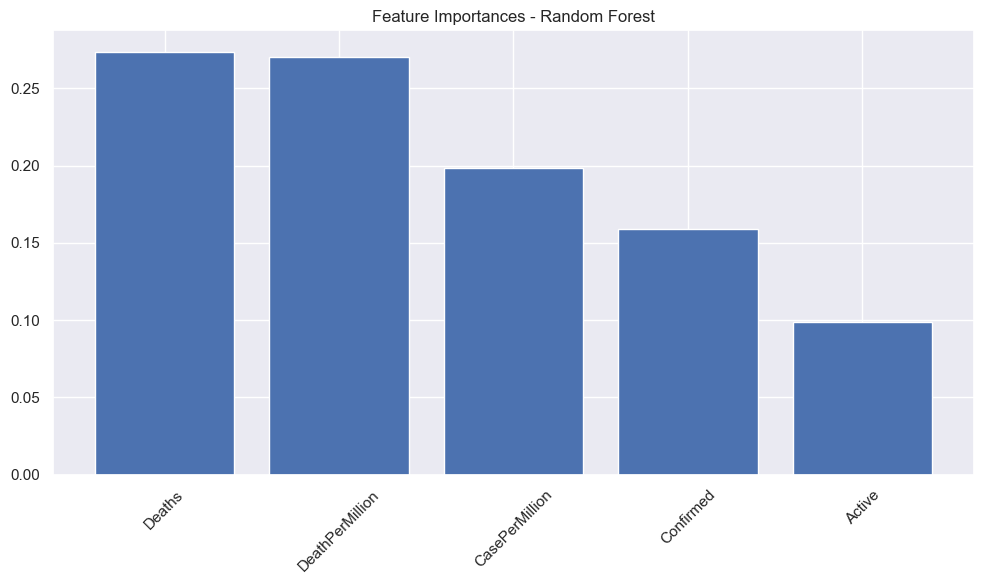

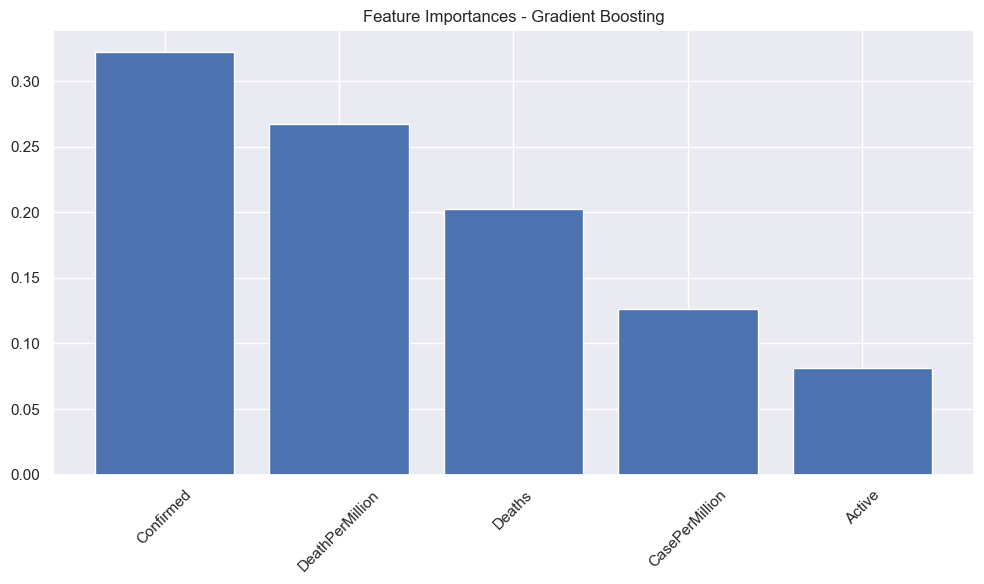

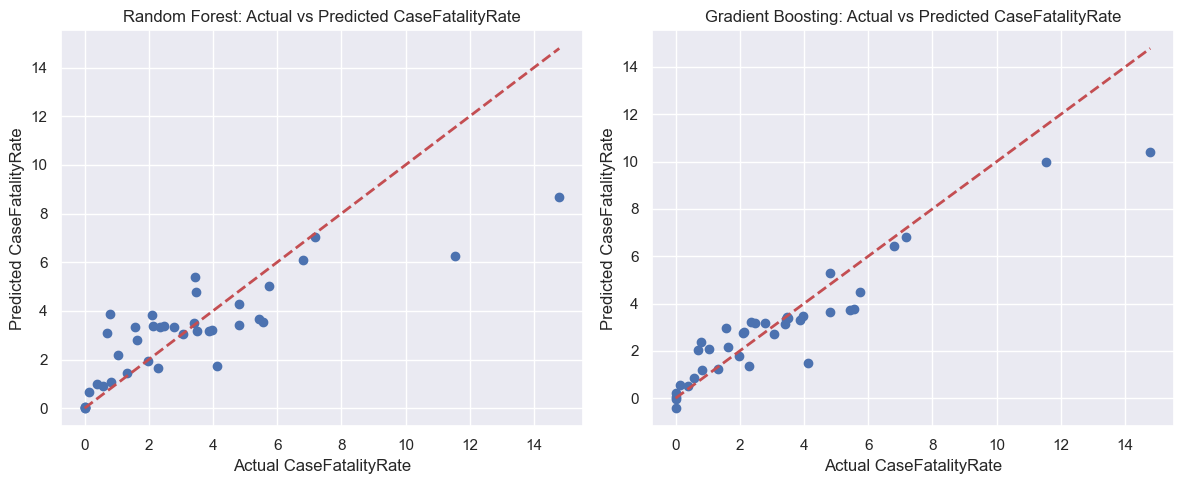

In [21]:
# Prepare the data
features = ['Confirmed', 'Deaths', 'Active', 'CasePerMillion', 'DeathPerMillion']
target = 'CaseFatalityRate'

# Group by country to get the latest data for each country
latest_data = covid_19_use.groupby('Country/Region').last().reset_index()


X = latest_data[features]
y = latest_data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.4f}, R2 Score: {r2:.4f}")

evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, gb_pred, "Gradient Boosting")

# Feature importance
def plot_feature_importance(model, features, model_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances - {model_name}")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_model, features, "Random Forest")
plot_feature_importance(gb_model, features, "Gradient Boosting")

# Scatter plot of actual vs predicted values
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(y_test, rf_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual CaseFatalityRate")
plt.ylabel("Predicted CaseFatalityRate")
plt.title("Random Forest: Actual vs Predicted CaseFatalityRate")

plt.subplot(122)
plt.scatter(y_test, gb_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual CaseFatalityRate")
plt.ylabel("Predicted CaseFatalityRate")
plt.title("Gradient Boosting: Actual vs Predicted CaseFatalityRate")

plt.tight_layout()
plt.show()

Nigeria COVID-19 Statistics:
Total Confirmed Cases: 41,180
Total Deaths: 860
Total Recovered: 18,203
Population: 206,606,300.0
Case Fatality Rate: 2.09%
Case Recovery Rate: 44.20%


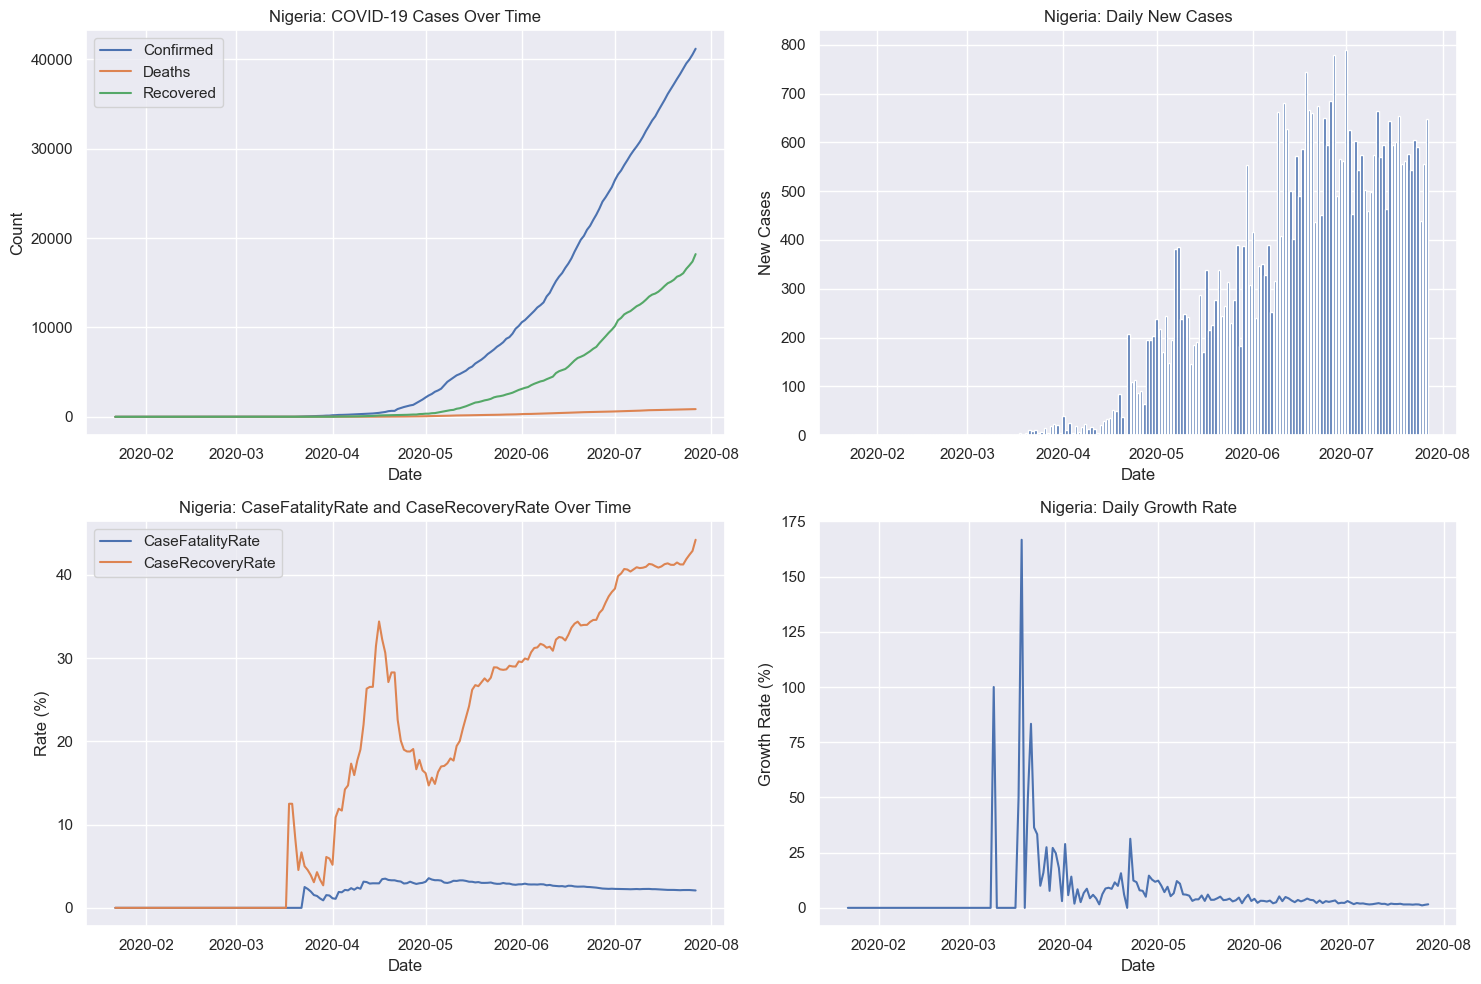


Peak daily cases: 790 on 2020-07-01
Peak daily deaths: 31 on 2020-06-16

Current active cases: 22,117


In [23]:
# Extract Nigeria data
nigeria_data = covid_19_use[covid_19_use['Country/Region'] == 'Nigeria'].copy()

# Set Date as index for time series analysis
nigeria_data = nigeria_data.set_index('Date').sort_index()

# Basic statistics
print("Nigeria COVID-19 Statistics:")
print(f"Total Confirmed Cases: {nigeria_data['Confirmed'].max():,}")
print(f"Total Deaths: {nigeria_data['Deaths'].max():,}")
print(f"Total Recovered: {nigeria_data['Recovered'].max():,}")
print(f"Population: {nigeria_data['Population'].iloc[0]:,}")
print(f"Case Fatality Rate: {nigeria_data['CaseFatalityRate'].iloc[-1]:.2f}%")
print(f"Case Recovery Rate: {nigeria_data['CaseRecoveryRate'].iloc[-1]:.2f}%")

# Time series plots
plt.figure(figsize=(15, 10))

# Confirmed, Deaths, Recovered
plt.subplot(2, 2, 1)
plt.plot(nigeria_data.index, nigeria_data['Confirmed'], label='Confirmed')
plt.plot(nigeria_data.index, nigeria_data['Deaths'], label='Deaths')
plt.plot(nigeria_data.index, nigeria_data['Recovered'], label='Recovered')
plt.title('Nigeria: COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

# Daily new cases
plt.subplot(2, 2, 2)
daily_new_cases = nigeria_data['Confirmed'].diff()
plt.bar(nigeria_data.index, daily_new_cases)
plt.title('Nigeria: Daily New Cases')
plt.xlabel('Date')
plt.ylabel('New Cases')

# Case Fatality Rate and Case Recovery Rate over time
plt.subplot(2, 2, 3)
plt.plot(nigeria_data.index, nigeria_data['CaseFatalityRate'], label='CaseFatalityRate')
plt.plot(nigeria_data.index, nigeria_data['CaseRecoveryRate'], label='CaseRecoveryRate')
plt.title('Nigeria: CaseFatalityRate and CaseRecoveryRate Over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()

# Daily Growth Rate
plt.subplot(2, 2, 4)
plt.plot(nigeria_data.index, nigeria_data['DailyGrowthRate'])
plt.title('Nigeria: Daily Growth Rate')
plt.xlabel('Date')
plt.ylabel('Growth Rate (%)')

plt.tight_layout()
plt.show()

# Calculate peak statistics
peak_cases_date = nigeria_data['Confirmed'].diff().idxmax()
peak_cases = nigeria_data['Confirmed'].diff().max()
peak_deaths_date = nigeria_data['Deaths'].diff().idxmax()
peak_deaths = nigeria_data['Deaths'].diff().max()

print(f"\nPeak daily cases: {peak_cases:.0f} on {peak_cases_date.date()}")
print(f"Peak daily deaths: {peak_deaths:.0f} on {peak_deaths_date.date()}")

# Calculate current active cases
current_active = nigeria_data['Active'].iloc[-1]
print(f"\nCurrent active cases: {current_active:,}")

*Key insights from Nigeria COVID-19 analysis*

1. Confirmed cases have increased exponentially over time, reaching over 41,000 cases by the end of the time period shown.

2. The case fatality rate (percentage of confirmed cases that result in deaths) is around 2%, while the case recovery rate has steadily increased to around 44%.

3. The daily new cases have shown high volatility, with several large spikes throughout the time period, indicating the uneven nature of the outbreak in Nigeria.

4. The daily growth rate of new cases has been highly variable, ranging from under 10% to over 150% on certain days, reflecting the dynamic and unpredictable pattern of the pandemic's progression in the country.

Overall, the data shows the significant impact COVID-19 has had in Nigeria, with confirmed cases and deaths increasing substantially over time, while recovery rates have improved but remain below 70%. The high volatility in daily new cases and growth rates underscores the challenges Nigeria has faced in controlling the outbreak.

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1711.883, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1674.626, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1654.964, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1710.382, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1656.955, Time=0.15 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1656.956, Time=0.24 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1658.180, Time=0.28 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1658.919, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 1.501 seconds
ARIMA Model RMSE for Nigeria: 1092.935186574334


c:\Users\Hello World!\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hello World!\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hello World!\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


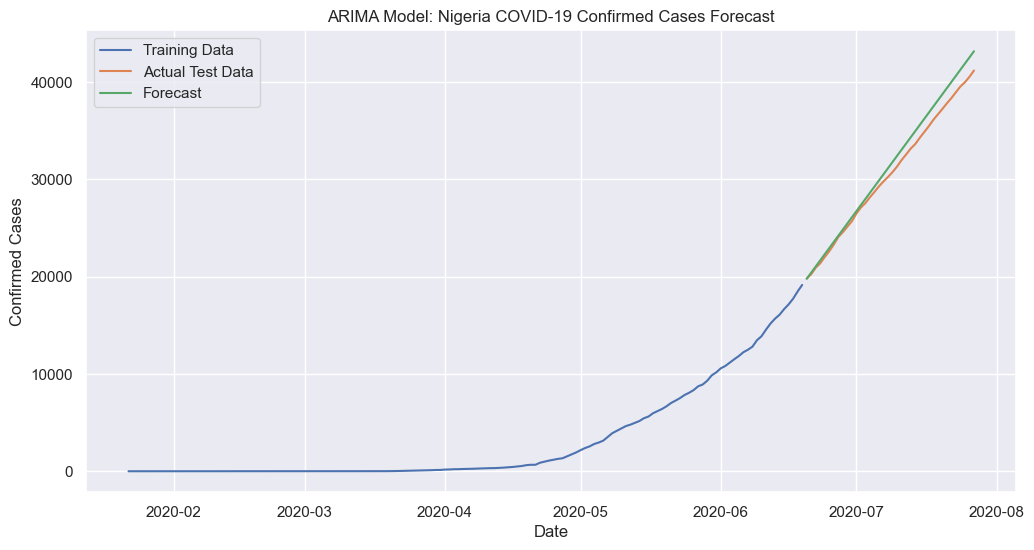

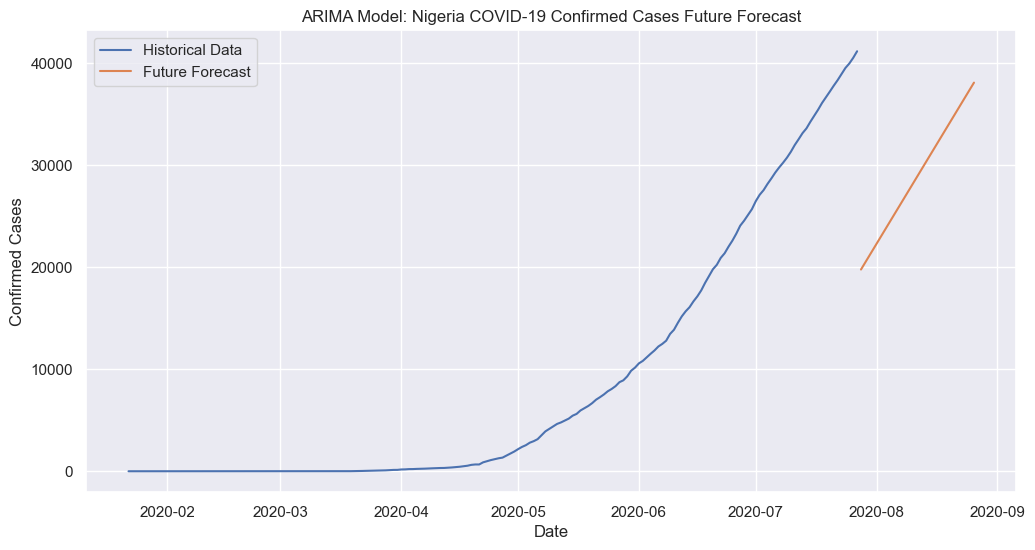

In [ ]:
# ARIMA Model for Nigeria's Confirmed Cases

# Extract Nigeria data
nigeria_data = covid_19_use[covid_19_use['Country/Region'] == 'Nigeria'].copy()

# Set Date as index for time series analysis
nigeria_data = nigeria_data.set_index('Date')

nigeria_cases = nigeria_data['Confirmed']

# Split the data into training and testing sets
train_size = int(len(nigeria_cases) * 0.8)
train, test = nigeria_cases[:train_size], nigeria_cases[train_size:]

# Use auto_arima to find the best ARIMA parameters
model_autoARIMA = auto_arima(train, start_p=0, start_q=0, test='adf', max_p=5, max_q=5, 
                             m=1, d=None, seasonal=False, start_P=0, D=0, trace=True, 
                             error_action='ignore', suppress_warnings=True, stepwise=True)

# Fit the ARIMA model
model = ARIMA(train, order=model_autoARIMA.order)
results = model.fit()

# Make predictions
forecast = results.forecast(steps=len(test))

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'ARIMA Model RMSE for Nigeria: {rmse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast, label='Forecast')
plt.title('ARIMA Model: Nigeria COVID-19 Confirmed Cases Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

# Forecast future cases
future_forecast = results.forecast(steps=30)  # Forecast for the next 30 days

# Plot the future forecast
plt.figure(figsize=(12, 6))
plt.plot(nigeria_cases.index, nigeria_cases, label='Historical Data')
plt.plot(pd.date_range(start=nigeria_cases.index[-1] + pd.Timedelta(days=1), periods=30), future_forecast, label='Future Forecast')
plt.title('ARIMA Model: Nigeria COVID-19 Confirmed Cases Future Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

*Key insights from Nigeria COVID-19 ARIMA plots*

1. The historical data (blue line) shows the exponential growth of confirmed cases over time, reaching over 40,000 cases by the end of July, 2020.

2. The future forecast (orange line) projects a continued exponential increase in confirmed cases, reaching over 35,000 cases by the end of June 2020 and over 40,000 cases by the end of July 2020.

3. The forecast indicates that the number of confirmed COVID-19 cases in Nigeria is expected to continue growing rapidly in the coming months, posing an ongoing challenge for the country's healthcare system and pandemic response efforts.

4. The forecast model appears to closely fit the historical data, suggesting the ARIMA approach used is reasonably effective at modeling the trajectory of the outbreak in Nigeria based on the available data.

Overall, this forecast plot provides a sobering outlook for the trajectory of the COVID-19 pandemic in Nigeria, highlighting the need for continued vigilance and effective public health interventions to mitigate the spread of the virus.

Machine Learning Model Results for Nigeria's Case Fatality Rate:
Random Forest - RMSE: 0.2163, R2 Score: 0.9689
Gradient Boosting - RMSE: 0.1364, R2 Score: 0.9876


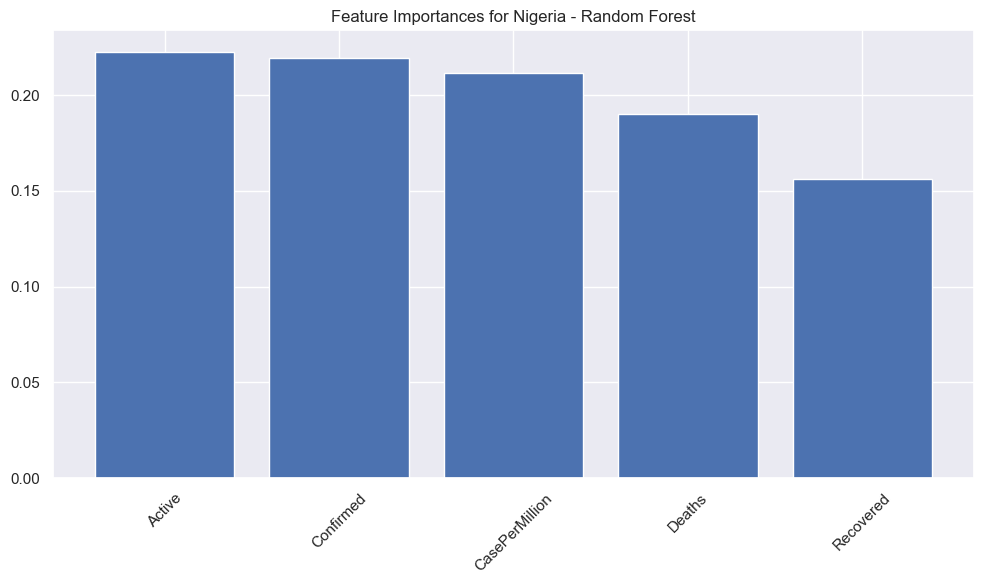

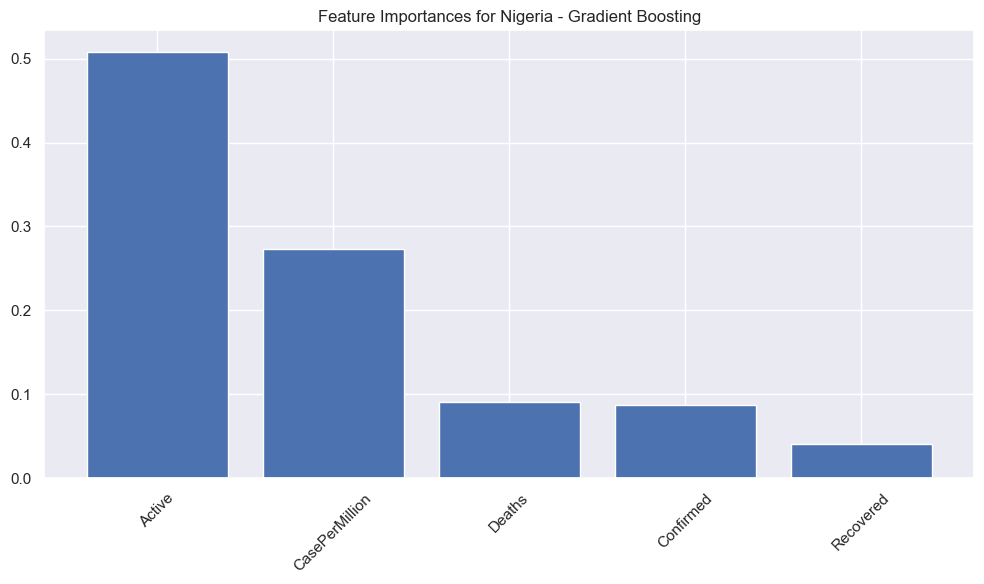

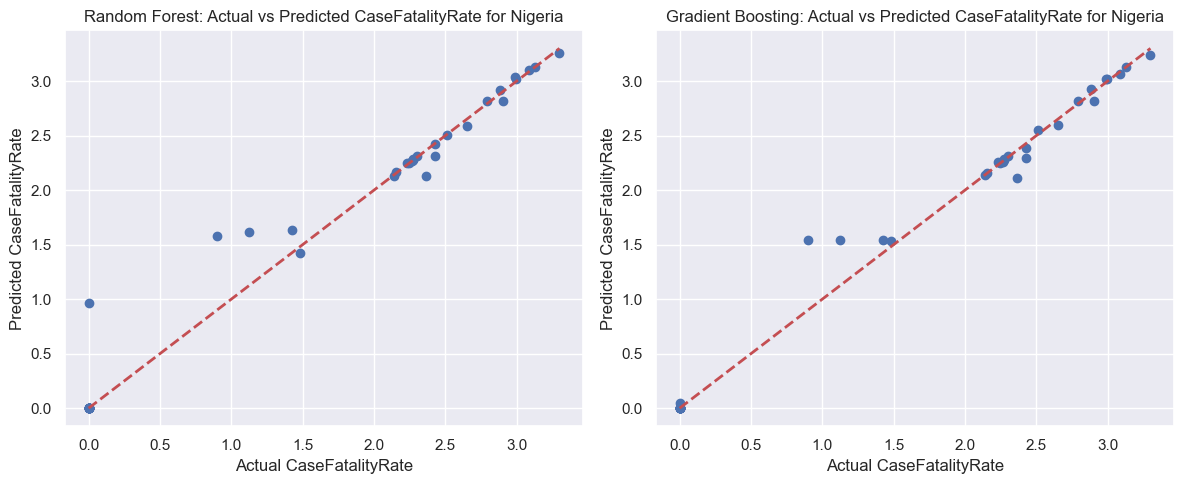

In [ ]:
# Machine Learning Models for Nigeria's Case Fatality Rate

# Prepare the data
features = ['Confirmed', 'Deaths', 'Recovered', 'Active', 'CasePerMillion']
target = 'CaseFatalityRate'

X = nigeria_data[features]
y = nigeria_data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.4f}, R2 Score: {r2:.4f}")

print("Machine Learning Model Results for Nigeria's Case Fatality Rate:")
evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, gb_pred, "Gradient Boosting")

# Feature importance for Nigeria
def plot_feature_importance(model, features, model_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for Nigeria - {model_name}")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_model, features, "Random Forest")
plot_feature_importance(gb_model, features, "Gradient Boosting")

# Scatter plot of actual vs predicted values for Nigeria
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(y_test, rf_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual CaseFatalityRate")
plt.ylabel("Predicted CaseFatalityRate")
plt.title("Random Forest: Actual vs Predicted CaseFatalityRate for Nigeria")

plt.subplot(122)
plt.scatter(y_test, gb_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual CaseFatalityRate")
plt.ylabel("Predicted CaseFatalityRate")
plt.title("Gradient Boosting: Actual vs Predicted CaseFatalityRate for Nigeria")

plt.tight_layout()
plt.show()